## Compare JacobiKAN's ability in function interpolation with MLP (Multi-variable)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from JacobiKANLayer import JacobiKANLayer

In [2]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [3]:
alpha_1 = 2
beta_1 = 1
alpha_2 = 1
beta_2 = 2
alpha_3 = 3
beta_3 = 3

# Define MLP and JacobiKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
        
# Define the JacobiKAN model
class JacobiKAN(nn.Module):
    def __init__(self):
        super(JacobiKAN, self).__init__()
        # Instantiate layers of JacobiKANLayer with the correct dimensions
        self.jacobikan1 = JacobiKANLayer(2, 8, 8, alpha_1, beta_1)
        self.jacobikan2 = JacobiKANLayer(8, 16, 4, alpha_2, beta_2)
        self.jacobikan3 = JacobiKANLayer(16, 1, 4, alpha_3, beta_3)

    def forward(self, x):
        # Ensure the outputs of one layer are inputs to the next
        x = self.jacobikan1(x)
        x = self.jacobikan2(x)
        x = self.jacobikan3(x)
        return x


Epoch 1/2000, MLP Loss: 1.2946, JacobiKAN Loss: 3.0974
Epoch 101/2000, MLP Loss: 0.4639, JacobiKAN Loss: 0.3533
Epoch 201/2000, MLP Loss: 0.4026, JacobiKAN Loss: 0.3144
Epoch 301/2000, MLP Loss: 0.3640, JacobiKAN Loss: 0.2963
Epoch 401/2000, MLP Loss: 0.3136, JacobiKAN Loss: 0.2782
Epoch 501/2000, MLP Loss: 0.2884, JacobiKAN Loss: 0.2621
Epoch 601/2000, MLP Loss: 0.2705, JacobiKAN Loss: 0.2565
Epoch 701/2000, MLP Loss: 0.2509, JacobiKAN Loss: 0.2446
Epoch 801/2000, MLP Loss: 0.2516, JacobiKAN Loss: 0.2336
Epoch 901/2000, MLP Loss: 0.2678, JacobiKAN Loss: 0.2710
Epoch 1001/2000, MLP Loss: 0.2225, JacobiKAN Loss: 0.2361
Epoch 1101/2000, MLP Loss: 0.2195, JacobiKAN Loss: 0.2198
Epoch 1201/2000, MLP Loss: 0.2113, JacobiKAN Loss: 0.2434
Epoch 1301/2000, MLP Loss: 0.2185, JacobiKAN Loss: 0.4280
Epoch 1401/2000, MLP Loss: 0.2675, JacobiKAN Loss: 0.3038
Epoch 1501/2000, MLP Loss: 0.1987, JacobiKAN Loss: 0.2035
Epoch 1601/2000, MLP Loss: 0.2261, JacobiKAN Loss: 0.2045
Epoch 1701/2000, MLP Loss:

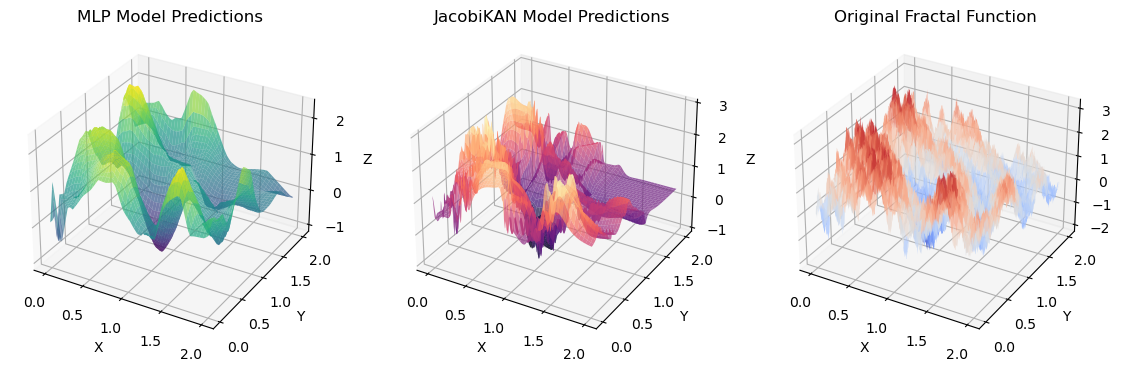

In [4]:
torch.autograd.set_detect_anomaly(True)

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

# Instantiate the models
mlp_model = SimpleMLP()  
Jacobi_model = JacobiKAN()

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
optimizer_Jacobi = torch.optim.Adam(Jacobi_model.parameters(), lr=0.01)

# Train the models
epochs = 2000
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_mlp.step()

    # JacobiKAN Training
    optimizer_Jacobi.zero_grad()
    outputs_Jacobi = Jacobi_model(x_train_2d)
    loss_Jacobi = criterion(outputs_Jacobi, y_train_2d)
    loss_Jacobi.backward()
    optimizer_Jacobi.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, JacobiKAN Loss: {loss_Jacobi.item():.4f}')

# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_mlp = mlp_model(x_test_2d).detach().numpy()
y_pred_Jacobi = Jacobi_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax1.set_title('MLP Model Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_Jacobi.reshape(X_test.shape), cmap='magma', alpha=0.7, label='JacobiKAN Prediction')
ax2.set_title('JacobiKAN Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
plt.show()